# How to define an evaluation task

This notebook demonstrates how bobbin can help building evaluation.

## Preamble: Install prerequisites, import modules.

In [1]:
!pip -q install --upgrade pip
!pip -q install --upgrade "jax[cpu]"
!pip -q uninstall -y bobbin
!pip -q install --upgrade git+https://github.com/yotarok/bobbin.git

In [66]:
%%capture
from typing import Tuple

import bobbin
import chex
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [67]:
chex.set_n_cpu_devices(8)

Array = chex.Array

## Prepare a model to be evaluated

First, we train a small model to be evaluated over the MNIST datasets.  For more details in training with bobbin, please refer [How to write a training loop](https://bobbin.readthedocs.io/en/latest/train_task.html).

The function below is a definition for dataset pipelines.

In [68]:
def get_dataset(batch_size, *, is_train=True, split="train"):
    ds = tfds.load("mnist", split=split, as_supervised=True)
    if is_train:
        ds = ds.repeat().shuffle(1024)
    ds = ds.batch(batch_size).prefetch(1)
    return ds

Note that the dataset is infinite only when `is_train == True`.

Here, a simple linear classifier is defined as a Flax module, also `bobbin.TrainTask` subclass is implemented for defining cross-entropy trainng over that simple classifier. (See [training doc](https://bobbin.readthedocs.io/en/latest/train_task.html) for details.)

In [69]:
class MnistLinearClassifier(nn.Module):
    @nn.compact
    def __call__(self, x: Array) -> Array:
        batch_size, *unused_image_dims = x.shape
        x = x.reshape((batch_size, -1))  # flatten the input image.
        return nn.Dense(features=10)(x)


class MnistTrainingTask(bobbin.TrainTask):
    def __init__(self):
        super().__init__(
            MnistLinearClassifier(),
            example_args=(
                np.zeros((1, 28, 28, 1), np.float32),  # comma-here is important
            ),
        )

    def compute_loss(self, params, batch, *, extra_vars, prng_key, step):
        images, labels = batch
        logits = self.model.apply({"params": params}, images)
        per_sample_loss = optax.softmax_cross_entropy(
            logits=logits, labels=jax.nn.one_hot(labels, 10)
        )
        return jnp.mean(per_sample_loss), ({}, None)


task = MnistTrainingTask()
train_state = task.initialize_train_state(
    jax.random.PRNGKey(0), optax.sgd(0.001, momentum=0.9)
)
train_step_fn = task.make_training_step_fn()

500 steps of stochastic gradient descent are done as follows:

In [70]:
prng_key = jax.random.PRNGKey(0)
for batch in get_dataset(64).take(500).as_numpy_iterator():
    rng, prng_key = jax.random.split(prng_key)
    train_state, step_info = train_step_fn(train_state, batch, rng)
print(f"Last loss value = {step_info.loss}")

2023-02-20 16:38:13.303908: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Last loss value = 107.15328979492188


2023-02-20 16:38:17.544889: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Define EvalResults

First, we define the metric used for evaluation.
Here, also for demonstrating [`SampledSet`](https://bobbin.readthedocs.io/en/latest/api.html#bobbin.SampledSet), the result is containing both confusion matrices and sampled triples of inputs, outputs, and labels.

In [96]:
class EvalResults(bobbin.EvalResults):
    confusion_matrix: Array
    examples: bobbin.SampledSet[Tuple[int, int, Array]] = flax.struct.field(
        pytree_node=False, default=bobbin.SampledSet(max_size=4)
    )
    dataset_name: str = flax.struct.field(pytree_node=False, default="")

    def prediction_count(self) -> int:
        return jnp.sum(self.confusion_matrix)

    def correct_count(self) -> int:
        return jnp.sum(jnp.diag(self.confusion_matrix))

    def accuracy(self) -> float:
        return self.correct_count() / self.prediction_count()

    def reduce(self, other: "EvalResults") -> "EvalResults":
        return type(self)(
            confusion_matrix=self.confusion_matrix + other.confusion_matrix,
            examples=self.examples.union(other.examples),
        )

`EvalResults` is a subclass of `flax.dataclass.PyTreeNode` that means that it follows Python's dataclass semantics. The type annotations at the beginning of the class definition are also used as a list of fields, and some special methods, e.g. constructors, are created automatically according to the list of fields.

Here, it should be noted that some of fields ("examples" and "dataset_name" in this example) are explicitly excluded from pytree definition by setting `pytree_node=False`.  This is especially important when we do use JIT-ed function in the `EvalTask` below. Anything that is passed to the compiled (JIT-ed) function must have a jax representation, and some types like `str` doesn't have that. Therefore, we have to exclude those things from pytree so they are treated as non-jax variables.

A subclass of `bobbin.EvalTask` is defined for implementing how to compute `EvalResults` above.

In [97]:
class EvalTask(bobbin.EvalTask):
    def __init__(self):
        self.model = MnistLinearClassifier()

    def create_eval_results(self, dataset_name):
        return EvalResults(
            confusion_matrix=np.zeros((10, 10)),
            examples=bobbin.SampledSet(max_size=4),
            dataset_name=dataset_name,
        )

    def evaluate(self, batch, model_vars) -> EvalResults:
        inputs, labels = batch
        logits = self.model.apply(model_vars, inputs)
        predicts = logits.argmax(axis=-1)
        confusion_mat = jnp.dot(
            jax.nn.one_hot(predicts, 10).T, jax.nn.one_hot(labels, 10)
        )
        examples = bobbin.SampledSet(max_size=4).union(
            zip(predicts, labels, list(inputs))
        )
        return EvalResults(confusion_matrix=confusion_mat, examples=examples)

`EvalTask.create_eval_results` is used for initializing the `EvalResults` instance.  For each incoming batch, `EvalTask.evaluate` is called, and the results are combined following the pseudo-code below:

```python
result = eval_task.create_eval_results(...)
for b in batches:
    result = result.reduce(eval_task.evaluate(b, ...))
```

The datasets given to the evaluation process are represented as a (nullary) function that returns iterator of batches.
If we use `tf.data` API for representing the dataset, we can easily obtain such function as follows:

In [98]:
eval_datasets = {
    "train": get_dataset(32, split="train[:1000]", is_train=False).as_numpy_iterator,
    "test": get_dataset(32, split="test", is_train=False).as_numpy_iterator,
}

Actual computation can be invoked by calling `bobbin.eval_datasets` as below.  (The function below basically just performs the for-loop based implementation written in the pseudo-code above, so you may write it down on your codebase.)

In [99]:
eval_task = EvalTask()
all_results = bobbin.eval_datasets(
    eval_task, eval_datasets, {"params": train_state.params}
)
all_results.keys()

2023-02-20 17:32:36.162711: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


dict_keys(['train', 'test'])

Here, you obtained `all_results: dict[str, EvalResults]` containing accumulated results for each dataset given.
You can compute accuracies over the results, and also visualize the confusion matrix, as follows:

dataset=train:	Accuracy = 0.8629999756813049
dataset=test:	Accuracy = 0.8439000248908997


Text(0.5, 1.0, 'test')

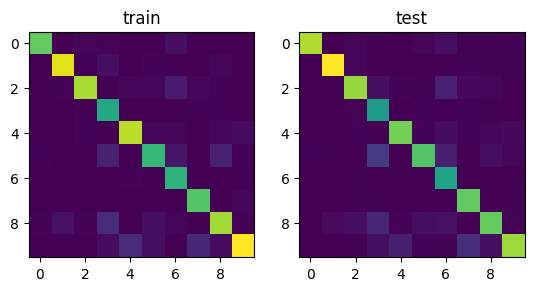

In [102]:
for dataset_name, results in all_results.items():
    print(f"dataset={dataset_name}:\tAccuracy = {results.accuracy()}")

plt.subplot(1, 2, 1)
plt.imshow(all_results["train"].confusion_matrix)
plt.title("train")
plt.subplot(1, 2, 2)
plt.imshow(all_results["test"].confusion_matrix)
plt.title("test")

`EvalResults.examples` field holds 4 random samples of input-label-output triples. Here, we can visualize how classifier worked as follows:

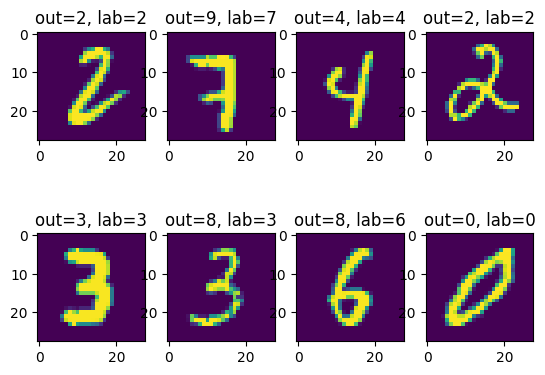

In [103]:
index = 1
for pred, lab, inputs in all_results["train"].examples:
    plt.subplot(2, 4, index)
    plt.imshow(inputs.reshape((28, 28)))
    plt.title(f"out={pred}, lab={lab}")
    index += 1
for pred, lab, inputs in all_results["test"].examples:
    plt.subplot(2, 4, index)
    plt.imshow(inputs.reshape((28, 28)))
    plt.title(f"out={pred}, lab={lab}")
    index += 1